In [2]:
import scipy.io as sio 
import numpy as np
import math
import time
import mindspore as ms
import mindspore.nn as nn
from mindspore import Tensor, ops
from mindquantum.core.circuit import Circuit, UN, controlled
from mindquantum.core.gates import H, X, Y, Z, RZ, RY, RX
from mindquantum.core.parameterresolver import PRGenerator, ParameterResolver
from mindquantum.core.operators import QubitOperator, Hamiltonian
from mindquantum.simulator import Simulator
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz
from mindquantum.framework import MQLayer                                      # 搭建神经网络
from mindspore.nn import SoftmaxCrossEntropyWithLogits, MSELoss                # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
from mindspore.dataset import NumpySlicesDataset                               # 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集
from sklearn.model_selection import train_test_split

In [3]:
envir = 'indoor' #'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels

# Data loading
if envir == 'indoor':
    mat = sio.loadmat('data/DATA_Htrainin.mat') 
    x_train = mat['HT'] # array
#    mat = sio.loadmat('data/DATA_Hvalin.mat')
#    x_val = mat['HT'] # array
#    mat = sio.loadmat('data/DATA_Htestin.mat')
#    x_test = mat['HT'] # array

elif envir == 'outdoor':
    mat = sio.loadmat('data/DATA_Htrainout.mat') 
    x_train = mat['HT'] # array
#    mat = sio.loadmat('data/DATA_Hvalout.mat')
#    x_val = mat['HT'] # array
#    mat = sio.loadmat('data/DATA_Htestout.mat')
#    x_test = mat['HT'] # array

x_train = x_train.astype('float32')
#x_val = x_val.astype('float32')
#x_test = x_test.astype('float32')
x_train = np.reshape(x_train, (len(x_train), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
#x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
#x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [200]:
# network params
residual_num = 2
encoded_dim = 128  #compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32
qubit_num = int(np.log(encoded_dim) / np.log(2))

# 定义哈密顿量
def create_ham(n_qubits=qubit_num):
    op_1 = QubitOperator(f'Z{n_qubits}') + QubitOperator(f'Z{n_qubits+1}') + QubitOperator(f'Z{n_qubits+2}')
    op_2 = QubitOperator(f'Z{n_qubits} Z{n_qubits+1}') + QubitOperator(f'Z{n_qubits} Z{n_qubits+2}') + QubitOperator(f'Z{n_qubits+1} Z{n_qubits+2}')
    op_3 = QubitOperator(f'Z{n_qubits} Z{n_qubits+1} Z{n_qubits+2}')
    op = (op_1 + op_2 + op_3 + QubitOperator('I0')) / 2**(3)
    return Hamiltonian(op)

# 定义常用方法
class CommonLayer(nn.Cell):
    def __init__(self, input_channels):
        super(CommonLayer, self).__init__()
        self.batch_norm = nn.BatchNorm2d(input_channels)
        self.leaky_relu = nn.LeakyReLU()

    def construct(self, y):
        y = self.batch_norm(y)
        y = self.leaky_relu(y)
        return y

# 定义经典网络类
class ClassicalLayer(nn.Cell):
    def __init__(self, encoded_dim, img_channels, img_height, img_width, img_total):
        super(ClassicalLayer, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.img_total = img_total
        
        # 编码器部分
        self.encoder_conv = nn.Conv2d(img_channels, 2, kernel_size=3, stride=1, pad_mode='pad', padding=1)
        self.common_layers = CommonLayer(2)
        self.flatten = ops.Flatten()
        self.dense_encoded = nn.Dense(2 * (img_height // 1) * (img_width // 1), encoded_dim)
        self.tanh = nn.Tanh()
        self.arccos = ops.ACos()

    def construct(self, x):
        # 编码器
        if not isinstance(x, Tensor):
            x = Tensor(x)
        x = self.encoder_conv(x)
        x = self.common_layers(x)        
        x = self.flatten(x)
        x = self.dense_encoded(x)
        x = self.tanh(x)
        return x

# 定义经典-量子编码线路
def quantum_encoder(codeword, n_qubits=qubit_num):                # 其中，x是传入的经典数据；0~n_qubits-1用来编码数据，n_qubits用来辅助编码
    def int_to_binary_list_fixed_length(n, length=n_qubits):
        return [int(digit) for digit in format(n, f'0{length}b')[-length:]]
     
    basis_list = []
    for i in range(2**n_qubits):
        basis_list.append(int_to_binary_list_fixed_length(i))
    
    # 将 codeword 转换为 ParameterResolver 对象
    beta = ParameterResolver({f'beta_{i}': val for i, val in enumerate(codeword.asnumpy())})
    encoder = Circuit()
    
    for state_index, state in enumerate(basis_list):
        for qubit_index, qubit_value in enumerate(state):
            if qubit_value == 0:
                encoder += X.on(qubit_index)
        encoder += RY(f'beta_{i}').on(n_qubits,range(n_qubits))
        for qubit_index, qubit_value in enumerate(state):
            if qubit_value == 0:
                encoder += X.on(qubit_index)    
    return encoder, beta

# 定义量子残差线路
def quantum_ansatz(n_qubits=qubit_num, num=residual_num):
    ansatz = Circuit()
    QNN = HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq=[RY], entangle_gate=X, depth=1).circuit
    for i in range(1,num+1):
        ansatz += H.on(n_qubits+i)
        ansatz += controlled(QNN)(n_qubits+i)
        ansatz += H.on(n_qubits+i)
    return ansatz

# 连接编码线路和残差线路
'''
def quantum_circuit(n_qubits=qubit_num, num=residual_num):
    circ = quantum_encoder(n_qubits).as_encoder() + quantum_ansatz(n_qubits, num).as_ansatz()
    return circ
'''
# 定义量子神经网络类
class QuantumLayer(nn.Cell):
    def __init__(self, n_qubits=qubit_num, num=residual_num):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.num = num
        self.ham = create_ham(n_qubits)

    def construct(self, codeword):
        # 构建编码器电路
        encoder_circ, _ = quantum_encoder(codeword, self.n_qubits)
        
        # 构建残差电路
        ansatz_circ = quantum_ansatz(self.n_qubits, self.num)
        
        # 连接编码器和残差电路
        total_circ = encoder_circ + ansatz_circ
        
        # 创建 MQLayer 并计算期望值
        grad_ops = sim.get_expectation_with_grad(self.ham, total_circ)
        QuantumNet = MQLayer(grad_ops)
       
        return QuantumNet

'''# 定义量子神经网络类
class QuantumLayer(nn.Cell):
    def __init__(self, n_qubits=qubit_num):
        super(QuantumLayer, self).__init__()
        self.circ = quantum_circuit
#        self.encoder_params_name = encoder_params_name
#        self.ansatz_params_name = ansatz_params_name
        self.simulator = Simulator('mqvector', n_qubits+1+residual_num)
        self.ham = ham
        self.expectation = self.simulator.get_expectation_with_grad(self.ham, self.circ)

    def construct(self, x):
        exp_val = self.expectation(x, ParameterResolver({}))
        return exp_val
'''
# 构建混合网络
class HybridNet(nn.Cell):
    def __init__(self, classical_net, quantum_net):
        super(HybridNet, self).__init__()
        self.classical_net = classical_net
        self.quantum_net = quantum_net

    def construct(self, x):
        if not isinstance(x, Tensor):
            x = Tensor(x)
        codeword = self.classical_net(x)
        x_quantum = self.quantum_net(codeword)
        return x_quantum

In [201]:
#encoder_params_name = quantum_encoder().params_name
ansatz_params_name = quantum_ansatz().params_name

classical_layer = ClassicalLayer(encoded_dim, img_channels, img_height, img_width, img_total)
quantum_layer = QuantumLayer(qubit_num)
hybrid_net = HybridNet(classical_layer, quantum_layer)

loss_fn = nn.MSELoss()
optimizer = nn.Adam(hybrid_net.trainable_params(), learning_rate=0.01)

In [198]:
xx = classical_layer(x_train[0:1])
xx

Tensor(shape=[1, 128], dtype=Float32, value=
[[ 5.41741624e-02,  3.48456502e-02,  2.58451104e-02 ... -2.83135753e-03, -3.78940776e-02, -9.68787447e-03]])

In [203]:
hybrid_net(x_train[0:1].squeeze())

ValueError: For primitive[Conv2D], the x shape size must be equal to 4, but got 3.

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore\core\utils\check_convert_utils.cc:625 mindspore::CheckAndConvertUtils::CheckInteger


In [204]:
hybrid_net.trainable_params()

[Parameter (name=classical_net.encoder_conv.weight, shape=(2, 2, 3, 3), dtype=Float32, requires_grad=True),
 Parameter (name=classical_net.common_layers.batch_norm.gamma, shape=(2,), dtype=Float32, requires_grad=True),
 Parameter (name=classical_net.common_layers.batch_norm.beta, shape=(2,), dtype=Float32, requires_grad=True),
 Parameter (name=classical_net.dense_encoded.weight, shape=(128, 2048), dtype=Float32, requires_grad=True),
 Parameter (name=classical_net.dense_encoded.bias, shape=(128,), dtype=Float32, requires_grad=True)]

In [5]:
from mindquantum.algorithm.library import amplitude_encoder
?amplitude_encoder

Signature: amplitude_encoder(x, n_qubits)
Docstring:
Quantum circuit for amplitude encoding.

Note:
    The length of classic data ought to be the power of 2, otherwise will be filled up with 0.
    The vector should be normalized.

Args:
    x (list[float] or numpy.array(list[float])): the vector of data you want to encode, which should be normalized.
    n_qubits (int): the number of qubits of the encoder circuit.

Returns:
    Circuit, the parameterized quantum circuit that do amplitude encoder.
    ParameterResolver, the parameter for parameterized quantum circuit to do
    amplitude encoder.

Examples:
    >>> from mindquantum.algorithm.library import amplitude_encoder
    >>> from mindquantum.simulator import Simulator
    >>> sim = Simulator('mqvector', 2)
    >>> encoder, parameterResolver = amplitude_encoder([0.5, -0.5, -0.5j, -0.5j], 2)
    >>> sim.apply_circuit(encoder, parameterResolver)
    >>> print(sim.get_qs(True))
    1/2¦00⟩
    -1/2¦01⟩
    -1/2j¦10⟩
    -1/2j¦11⟩
  

In [11]:
sim = Simulator('mqvector', 2)
encoder, parameterResolver = amplitude_encoder([0.5, -0.5, -0.5j, -0.5j], 2)
sim.apply_circuit(encoder, parameterResolver)
print(sim.get_qs(True))

1/2¦00⟩
-1/2¦01⟩
-1/2j¦10⟩
-1/2j¦11⟩


In [12]:
parameterResolver

ParameterResolver(dtype: float64,
  data: [
         alpha_10: 1.570796,
         alpha_11: 1.570796,
         alpha_20: 1.570796,
         lambda_10: 3.141593,
         lambda_11: 0.000000,
         lambda_20: -3.141593
  ],
  const: 0.000000
)

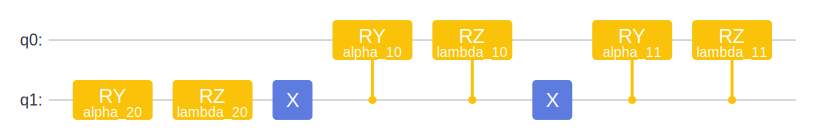

In [13]:
encoder.svg()

In [15]:
encoder.trainable_params()

AttributeError: 'Circuit' object has no attribute 'trainable_params'

In [35]:
# 创建一个包含参数化门的电路
circuit = Circuit()
circuit += RY('theta').on(0)
circuit += RX('phi').on(1)
circuit += X.on(0,1)
circuit += RY('theta').on(0)

# 使用 ParameterResolver 绑定参数值
pr = ParameterResolver({'theta': 0.3, 'phi': 0.3})
ham = Hamiltonian(QubitOperator('Z0'))
# 应用参数化电路并绑定参数值
sim = Simulator('mqvector', 2)
grad_op = sim.get_expectation_with_grad(ham, circuit)
exp, grad = grad_op(pr.params_value)
exp.shape, grad.shape

((1, 1), (1, 1, 2))

In [42]:
?update_param_value

Object `update_param_value` not found.


In [4]:
sim = Simulator('mqvector', 1)
sim.apply_circuit(Circuit().h(0))
sim.get_qs()

array([0.70710678+0.j, 0.70710678+0.j])

In [5]:
ham1 = Hamiltonian(QubitOperator('Z0', 0.5) + QubitOperator('I0', 0.5))

In [6]:
sim.apply_hamiltonian(ham1)

In [7]:
sim.get_qs()

array([0.70710678+0.j, 0.        +0.j])